# Retinalysis Registration: Example of Package Usage

This notebook demonstrates how to use the `rtnls_registration` package to perform retinal image registration, including expected inputs, and utility examples.


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from rtnls_registration import Registration, open_image
from rtnls_registration.utils import get_red_blue, plot_matches

def get_overlay(image, mask):
    overlay = np.copy(image)
    overlay[mask > 0] = 255
    return overlay

In [2]:
# images are expected to be 2D (HxW) or 3D (HxWxC) numpy arrays
# for color images, the green channel (channel 1) is used in the preprocessing step
image0 = open_image('sample/image0.png')
image1 = open_image('sample/image1.png')

# loading a binary mask
drusen0 = open_image('sample/drusen0.png')

# just defining some random coordinates for demonstration purposes
coordinates0 = np.array([[500, 500], [900, 500]])

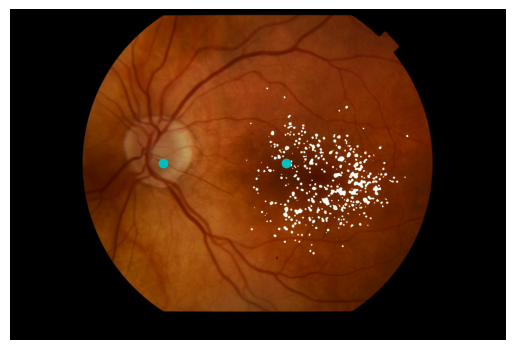

In [3]:
# visualize the input, mask and the coordinates
overlay = get_overlay(image0, drusen0)
plt.imshow(overlay)
plt.scatter(coordinates0[:,0], coordinates0[:,1], c='c')
plt.axis('off')
plt.show()

In [4]:
# create a registration object with default settings
registrator = Registration()
# the registrator object is callable, and returns a transform object
transform = registrator(image0, image1)
transform

CompositeTransform([ProjectiveTransform(sx=0.385, sy=0.376, det=0.145, rot=-1.8°) ∘ Polynomial2DTransform(degree=2, dx_bias=-1.143, dy_bias=1.119) ∘ ProjectiveTransform(sx=3.661, sy=3.661, det=13.400, rot=0.0°)])

In [5]:
# alternatively, you can set reference and target separately:
# this is useful if you want to reuse the registrator for different images (just update the reference or target)
registrator.set_reference(image0)
registrator.set_target(image1)
transform = registrator.run()
transform

CompositeTransform([ProjectiveTransform(sx=0.385, sy=0.376, det=0.145, rot=-1.8°) ∘ Polynomial2DTransform(degree=2, dx_bias=-1.143, dy_bias=1.119) ∘ ProjectiveTransform(sx=3.661, sy=3.661, det=13.400, rot=0.0°)])

In [6]:
# some timing stats 
registrator.stats

Timing Statistics:
preprocess_image0   : 0.454 s
extract_keypoints0  : 0.386 s
preprocess_image1   : 0.392 s
extract_keypoints1  : 0.370 s
get_ransac_transform: 0.002 s
apply_refine        : 1.566 s
get_quadratic_fit   : 0.008 s

In [7]:
# transform image0 to image1 (RGB image)
# pass the shape of the target image to the warp function 
# to ensure the output has the same shape as the target image
image0T = transform.warp(image0, image1.shape[:2])

# transform drusen0 to image1 (binary image)
drusen0T = transform.warp(drusen0, image1.shape[:2])

# transform coordinates (points list [[x0, y0], [x1, y1], ...])
coordinates0T = transform.apply(coordinates0)

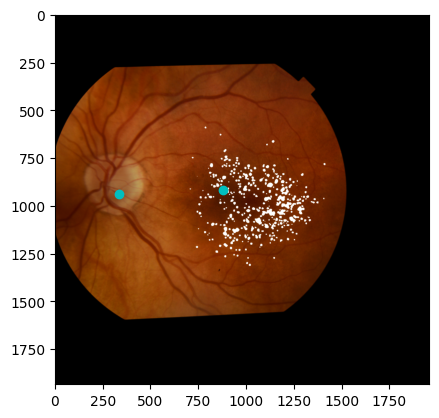

In [8]:
# visualize the transformed image, mask and coordinates
overlay = np.copy(image0T)
overlay[drusen0T > 0] = 255
plt.imshow(overlay)
plt.scatter(coordinates0T[:,0], coordinates0T[:,1], c='c')
plt.show()

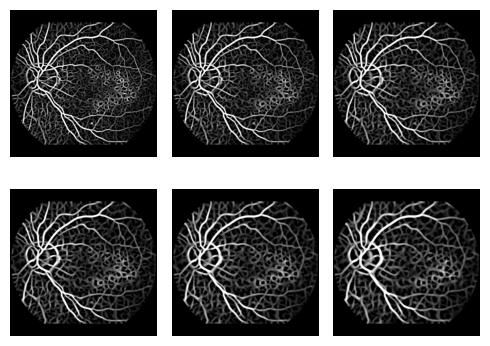

In [9]:
# visualize the preprocessed images (vessel enhancement)
fig, axes = plt.subplots(2,3, figsize=(5, 4))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(registrator.preprocess_result0.vessel_enhanced[i], cmap='gray')
    ax.axis('off')
plt.tight_layout()

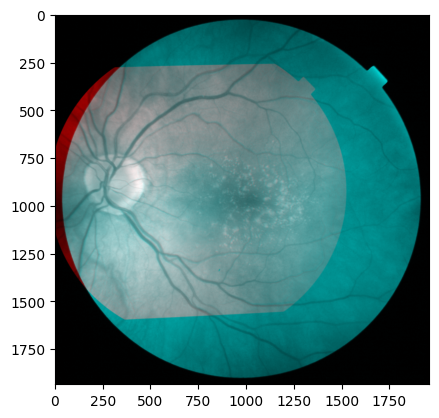

In [10]:
# overlay images (image0T mapped onto image1)
plt.imshow(get_red_blue(image0T, image1))

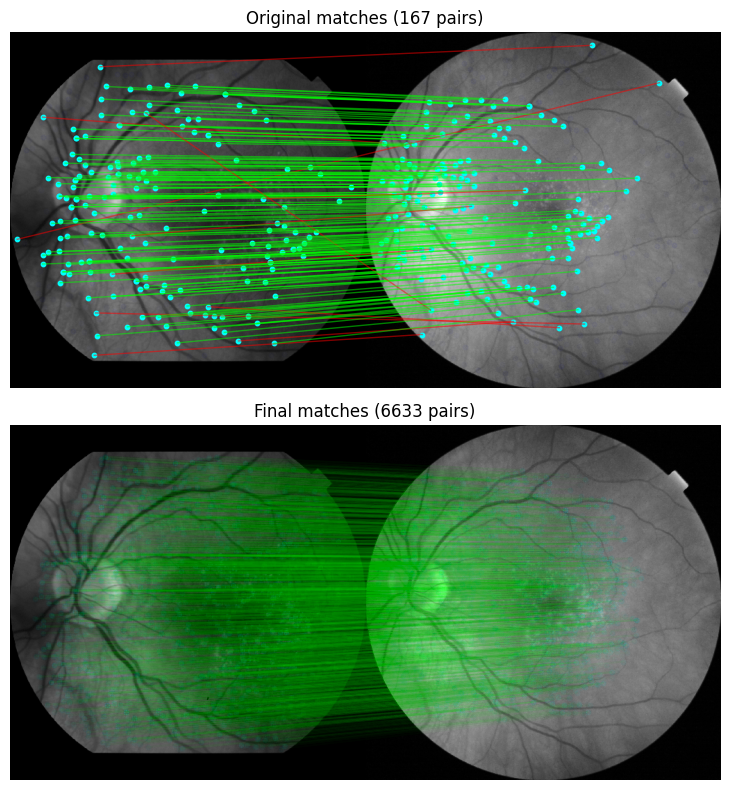

In [11]:
# original matches are used for the initial transformation matrix
# final matches are used to finetune the projective transform and make fit the polynomial fit
plot_matches(registrator)